Here, I'm going to explore some of the features of the dataset, use visualizations to help understand those features, and develop a model that solves the problem of imbalanced data by under- and over-sampling.

In [1]:
# import libraries
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


# Prepare Data

## Import

In [2]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)
     
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    
    return df

In [3]:
df = wrangle("poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


# Explore

In [5]:
# Inspect DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 1 to 10503
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   flo

That's solid information. We know all our features are numerical and that we have missing data. But, as always, it's a good idea to do some visualizations to see if there are any interesting trends or ideas we should keep in mind while we work. First, let's take a look at how many firms are bankrupt, and how many are not.

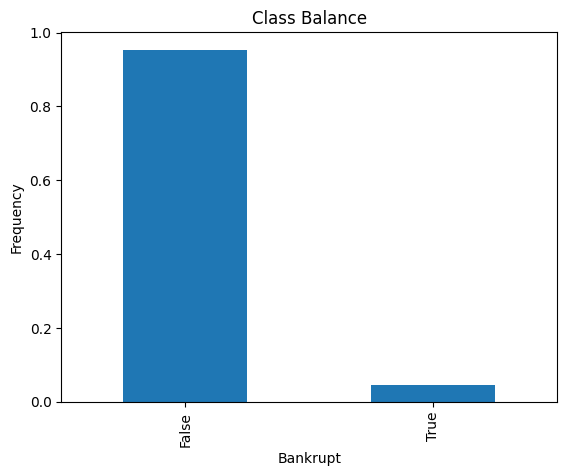

In [6]:
# Plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);
  

That's good news for Poland's economy! Since it looks like most of the companies in the dataset are doing all right for themselves, now I'll drill down a little farther. However, it also shows us that it is an imbalanced dataset, where the majority class is far bigger than the minority class.

In the first noteboook, we saw that there were 64 features of each company, each of which had some kind of numerical value. It might be useful to understand where the values for one of these features cluster, so I'll make a boxplot to see how the values in "feat_27" are distributed.

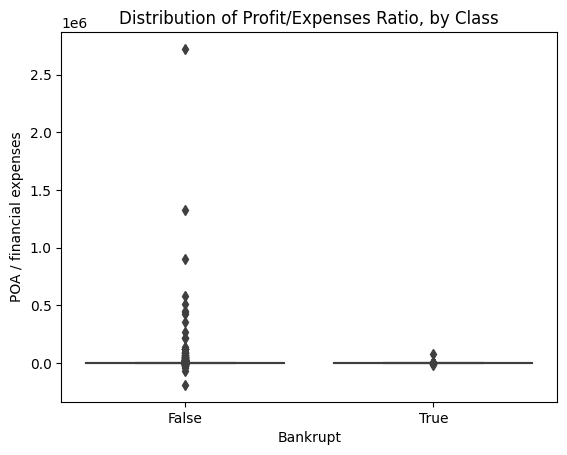

In [7]:
# Create boxplot
sns.boxplot(x="bankrupt", y="feat_27", data=df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

boxplots exist to help us see the quartiles in a dataset, and this one doesn't really do that. I'll check the distribution of "feat_27"to see if I can figure out what's going on here.

In [9]:
# Summary statistics for `feat_27`
df["feat_27"].describe().apply("{0:,.0f}".format)

count        9,312
mean         1,206
std         35,477
min       -190,130
25%              0
50%              1
75%              5
max      2,723,000
Name: feat_27, dtype: object

The median is around 1, but the mean is over 1000. That suggests that this feature is skewed to the right. I'll make a histogram to see what the distribution actually looks like.

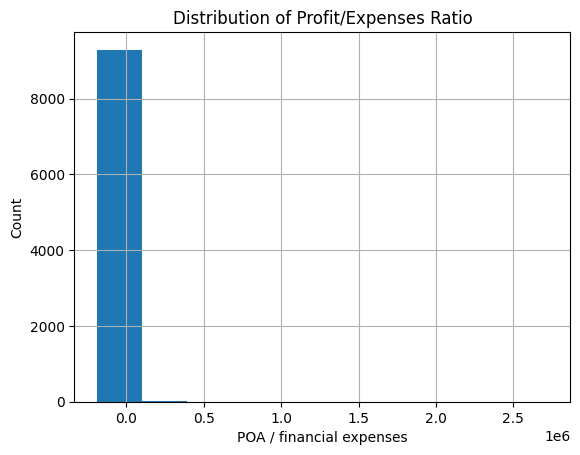

In [10]:
# Plot histogram of `feat_27`
df["feat_27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

The plot above confirms the data needs trimming.

In [11]:
q1, q9 = df["feat_27"].quantile([0.1, 0.9])
mask = df["feat_27"].between(q1, q9)
mask.head()

company_id
1     True
2    False
3     True
5    False
6     True
Name: feat_27, dtype: bool

Now i'll recreate the boxplot that I made above, this time only using the values for "feat_27" that fall between the 0.1 and 0.9 quantiles for the column.

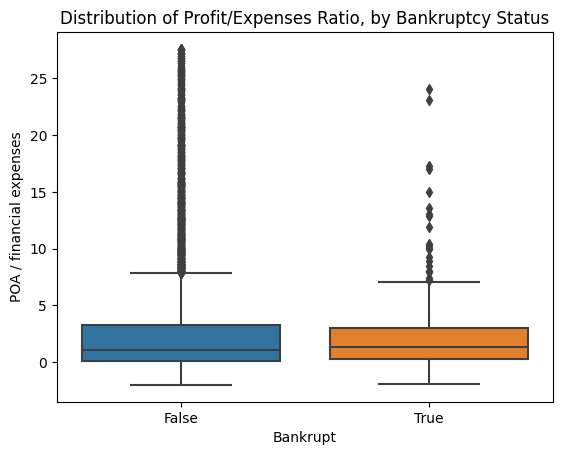

In [12]:
# Create clipped boxplot
q1, q9 = df["feat_27"].quantile([0.1, 0.9])
mask = df["feat_27"].between(q1, q9)
sns.boxplot(x="bankrupt", y="feat_27", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

<div class="alert alert-info" role="alert">
    <p><b>More context on <code>"feat_27"</code>:</b> <em>Profit on operating activities</em> is profit that a company makes through its "normal" operations. For instance, a car company profits from the sale of its cars. However, a company may have other forms of profit, such as financial investments. So a company's <em>total profit</em> may be positive even when its profit on operating activities is negative.
    <p><em>Financial expenses</em> include things like interest due on loans, and does not include "normal" expenses (like the money that a car company spends on raw materials to manufacture cars). 
   </div>

Considering how many features are in the dataset, I explored them seperately and most of them are skewed too. This will be important to keep in mind for model selection.
It is also important to check for multicolinearity which is what I'll be doing next.

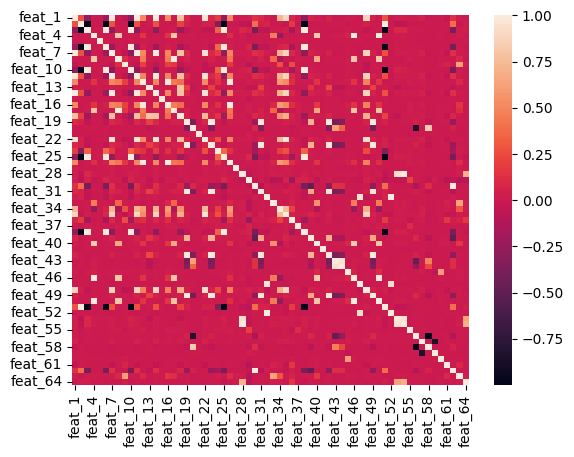

In [15]:
corr = df.drop(columns="bankrupt").corr()
sns.heatmap(corr);

From this EDA... First, the data is imbalanced. This is something that needs to be addressed in the data preparation. Second, many of the features have missing values that weill need imputing. And since the features are highly skewed, the best imputation strategy is likely median, not mean. Finally, there's also autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.


# Split

In [16]:
# Create feature matrix X and target vector y
target = "bankrupt"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In order to make sure that the model can generalize, I need to put aside a test set that I'll use to evaluate the model once it's trained.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


# Resample

Now that I've split the data into training and testing sets, I can address the class imbalance we saw during the EDA. One strategy is to resample the training data. There are many to do this, but I'd like to start with under-sampling.

When data is imbalanced in different classes, one way we can balance it is reducing the number of observations in the majority class. This is called **under-sampling**. We can under-sample by randomly deleting some observations in the majority class. The open source [imbalanced-learn](https://imbalanced-learn.org/stable/) (imported as `imblearn`) is an open-source library that works with `scikit-learn` and provides tools when dealing with imbalanced classes. Here's an example of randomly deleting observations from the majority class using Poland bankruptcy data from 2008.

In [18]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(768, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.121400,0.097238,0.74500,8.66160,25.8370,0.000000,0.158840,9.284100,2.7588,0.902760,...,775.71,0.075999,0.13447,0.94243,0.000000,4.9049,11.3390,12.865,28.3720,17.4870
1,0.316280,0.264920,0.65346,3.46660,55.1890,0.290140,0.316280,2.774700,2.4721,0.735080,...,1367.90,0.119990,0.43027,0.87412,0.000000,10.6020,4.5533,39.115,9.3314,30.2870
2,0.066615,0.890270,-0.48007,0.46076,-76.3080,0.047487,0.087936,-0.011406,1.0952,-0.010155,...,-46566.00,0.086894,-6.56010,0.91311,0.000000,32.0280,10.0480,105.220,3.4689,5.2362
3,0.208000,0.363630,0.33875,1.93160,-5.3169,0.251870,0.258280,1.603300,1.0535,0.583020,...,187050.00,0.050746,0.35676,0.94925,0.000000,34.8840,19.0030,24.498,14.8990,18.2040
4,0.096863,0.299320,0.35393,2.42640,31.5630,0.267550,0.125130,2.341000,1.0495,0.700680,...,2993.00,0.047123,0.13824,0.95288,0.073041,13.7820,6.8621,39.668,9.2013,5.7376


In [19]:
# check class balance
y_train_under.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

Now it's split equally across both classes but the issue with this is that a lot of tarining data was lost and they were not used to train the model and those data points may have had valuable information to improve the model performance.

Next I'll over sample

**Over-sampling** is the opposite of under-sampling. Instead of reducing the majority class, over-sampling increases the number of observations in the minority class by randomly making copies of the existing observations.

In [20]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


In [21]:
y_train_over.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

# Build Model

## Baseline

As always, I need to establish the baseline for the model. Since this is a classification problem, I'll use accuracy score.

In [22]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


Note here that, because the classes are imbalanced, the baseline accuracy is very high. We should keep this in mind because, even if our trained model gets a high validation accuracy score, that doesn't mean it's actually *good.* 

# Iterate

Now there's a baseline, I'l build model to see if I can beat it.

Here I'll create three identical models: model_reg, model_under and model_over. All of them would use a SimpleImputer followed by a DecisionTreeClassifier. I'll train model_reg using the unaltered training data. For model_under, I'll use the undersampled data. For model_over, I'll use the oversampled data.

In [23]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

# Evaluate

In [24]:
# Calculate training and test accuracy for all 3 models
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9359
Training Accuracy: 0.7421
Test Accuracy: 0.7104
Training Accuracy: 1.0
Test Accuracy: 0.9344


As I mentioned earlier, "good" accuracy scores don't tell much about the model's performance when dealing with imbalanced data. So instead of looking at what the model got right or wrong, let's see how its predictions differ for the two classes in the dataset. For this I'll be using a confusion matrix.

# Confusion Matrix
Accuracy score may not provide enough information to assess how a model is performing because it only gives us an overall score. Also, imbalanced data can lead to a high accuracy score even when a model isn't particularly useful. If we want to know what fraction of all positive predictions were correct and what fraction of positive observations did we identify, we can use a **confusion matrix**.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.

|                     | Positive Observation     | Negative Observation    |
|---------------------|:------------------------:|:-----------------------:|
| **Positive Prediction** |     True Positive (`TP`)   | False Positive (`FP`)     |
| **Negative Prediction** | False Negative (`FN`)      |     True Negative (`TN`)  |

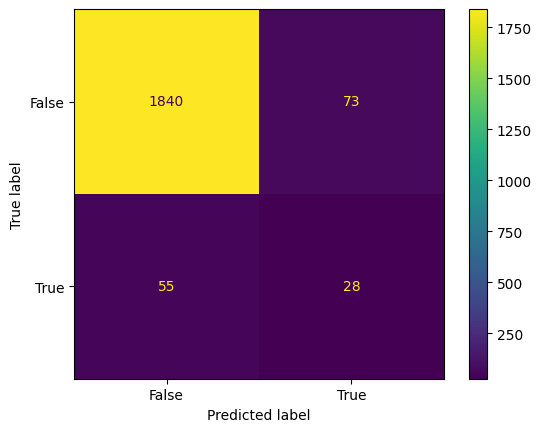

In [25]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test);

* Top left is the True Negative: The model correctly predicted the negative class.

* Top RIght is the False Positive: The model incorrectly predicted the positive class when the actual class was negative.

* Bottom Right is the False Negative: The model incorrectly predicted the negative class when the actual class was positive.

* Bottom Left is the True Positive: The model correctly predicted the positive class.

In this lesson, I didn't do any hyperparameter tuning, but it will be helpful in the next lesson to know what the depth of the tree model_over.

In [26]:
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

33


# Communicate


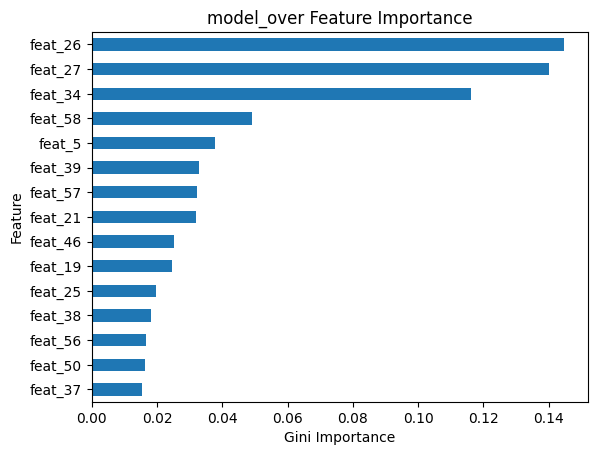

In [27]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");


There's our old friend `"feat_27"` near the top, along with features 34 and 26. It's time to share our findings.

Sometimes communication means sharing a visualization. Other times, it means sharing the actual model you've made so that colleagues can use it on new data or deploy your model into production. First step towards production: saving your model.


In [29]:
# Save the best performing model using a context manager
with open("model-5-2.pkl", "wb") as f:
    pickle.dump(model_over, f)